# **STAT-201 Project Proposal**
## Do data analysts and data scientists differ in salaries and work flexibility? 

Prabh Sehgal, Rainie Fu, Rishabh Mathur, Dennis Truong

## Introduction
A key factor in employee happiness is financial compensation, and past work during the COVID-19 pandemic have shown that working remotely can also have a positive impact on happiness thanks to increased employee autonomy (Card et al., 2012; Galanti et al., 2021). Our of data science salaries analysis aims to explore the relationships between different data science jobs, their salaries, and their proportions doing remote work. Our analyses can inform prospective emplyees about each position's remote work flexibility and typical salary. Employees may use these inferences to discover new data science occupations that better align with their work-life goals.

### Research Question

If full-time Data Scientists and Data Analysts were compared, is there a difference in the means of salaries and difference in proportions of remote work?


### Dataset

Our research utilizes the dataset "Data Science Job Salaries" by Ruchi Bhatia (2022) from [Kaggle](https://www.kaggle.com/datasets/ruchi798/data-science-job-salaries). Observations include the year the salary was paid, experience level, work kind, title, salary, remote ratio, firm size, and company location. The main observations we aim to use are the ```job_title``` to tell us the job type, the ```salary_in_USD``` to inform us about each role's salary, and the ```remote_ratio``` to give us the proportion of poeple working remotely in that respective role.


## Methods and Results

### Reading and cleaning
We downloaded the data to our repository and read it from there since Kaggle does not let datasets to be read straight from the website.

In [14]:
# Load libraries
install.packages("infer")
library(tidyverse)
library(infer)
library(repr)
library(ggplot2)
library(gridExtra)
library(RColorBrewer)
library(GGally)
library(scales)

#library(tidyverse)
library(broom)
#library(repr)
library(digest)
# library(infer)
# library(gridExtra)

# Set seed
set.seed(4204)

# Get url of dataset from the web|
url <- "https://raw.githubusercontent.com/vindennt/stat-201-project-group-10/main/ds_salaries.csv"

# Use suppressMessages() to avoid the warning message when it automatically gives a
# name to the first column, which are just indecies
salaries <- suppressMessages(
read_delim(url, delim = ",") %>%
select(!...1))

# Preview data
head(salaries)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>
2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L
2020,EN,FT,Data Analyst,72000,USD,72000,US,100,US,L


**Table 1:** Preview of the data science salary dataset to be analyzed.

As the salaries of part-time positions can vary due to various factors, we exclude them from our analysis 
and focus solely on the salaries for full-time positions.

In preparation for potential hypothesis testing using the Central Limit Theorem, we need to identify which 
job titles have a sample size that is sufficiently large (we consider n > 30 to be a large sample size, 
as discussed in class).

In [4]:
# Filter for sample size > 30 and full time workers
salaries <- salaries %>%
    filter(employment_type == "FT") %>%
    group_by(job_title) %>%
    mutate(n = n()) %>%
    filter(n > 30)

# Preview the remaining job titles
large_job_groups <- as.list(unique(salaries$job_title))
large_job_groups

[[1]]
[1] "Data Scientist"

[[2]]
[1] "Machine Learning Engineer"

[[3]]
[1] "Data Analyst"

[[4]]
[1] "Data Engineer"

Now let's only gather the information that we are interested in about these four titles:
1. salaries in usd (to enable salary comparison)
2. remote ratio, change the numerical values into categorical values for ease of visualization 


In [5]:
inperson <- salaries %>% # Classify no remote work as being in person work
    filter(remote_ratio == 0) %>%
    mutate(remote_ratio = "in person")
hybrid <- salaries %>%
    filter(remote_ratio == 50) %>% # Classify partial remote work as a hybrid format
    mutate(remote_ratio = "hybrid")
remote <- salaries %>%
    filter(remote_ratio == 100) %>%
    mutate(remote_ratio = "remote") # Classify 100% remote work as full remote work
# Remove unecessary columns
salaries_new <- rbind(inperson, hybrid, remote) %>%
    select(-salary_currency, -salary, -employee_residence, -company_location, -employment_type) 

# Preview resulting data
head(salaries_new)

work_year,experience_level,job_title,salary_in_usd,remote_ratio,company_size,n
<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<int>
2020,MI,Data Scientist,79833,in person,L,140
2020,EN,Data Scientist,51321,in person,S,140
2020,MI,Data Scientist,40481,in person,L,140
2020,EN,Data Scientist,39916,in person,M,140
2020,MI,Machine Learning Engineer,43331,in person,M,41
2020,SE,Data Engineer,33511,in person,S,129


**Table 2:** Preview of the cleaned and filtered data science salary dataset to be analyzed.

At this point, we think company size may also play a role in salary amounts and their ability to support more remote work. So, we will plot salary comparisons between Data Scientists and Data Analysts within each respective company size. 

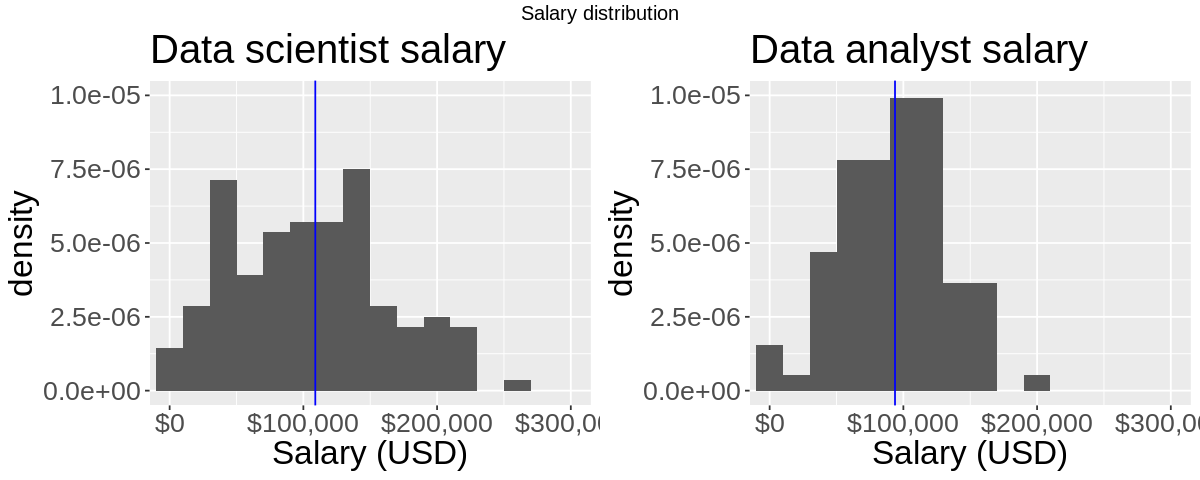

In [6]:
# Set graph sizes to be readable
options(repr.plot.width = 10, repr.plot.height = 4)

# # Filter for data scientists of large company sizes
# salaries_ds_large <- salaries_new %>%
#     filter(company_size == "L") %>%
#     filter(job_title == "Data Scientist")

# # Plot data scientist distribution after filtering
# ds_salary_dist <- salaries_ds_large %>%
#     ggplot(aes(x = salary_in_usd, y = after_stat(density))) +
#     geom_histogram(binwidth = 20000) +
#     labs(x = "Salary (USD)", title = "Data analyst salary") +
#     geom_vline(xintercept = mean(salaries_ds_large$salary_in_usd),color = "blue") + # mark the mean to make it easier to see
#     scale_x_continuous(labels = scales::dollar_format()) +  # put money in the human-readable unit of USD
#     coord_cartesian(xlim = c(0, 300000), ylim = c(0, 1e-05)) + # set x axis to readable scale
#     theme(text = element_text(size = 20)) # Set text size to easily readable size
    
# # Filter for data analysts of large company sizes
# salaries_pda_large <- salaries_new %>%
#     filter(company_size == "L") %>%
#     filter(job_title == "Data Analyst")

# #Plot data analyst  distribution after filtering
# pda_salary_dist <- salaries_pda_large %>%
#     ggplot(aes(x = salary_in_usd, y = after_stat(density))) +
#     geom_histogram(binwidth = 20000) +
#     labs(x = "Salary (USD)", title = "Data analyst salary") +
#     geom_vline(xintercept = mean(salaries_pda_large$salary_in_usd),color = "blue") +
#     scale_x_continuous(labels = scales::dollar_format()) +
#     coord_cartesian(xlim = c(0, 300000), ylim = c(0, 1e-05)) +
#     theme(text = element_text(size = 20))

# # Plot side by side comparison of the two graphs of each job role
# grid.arrange(ds_salary_dist, pda_salary_dist, ncol = 2, top = "Salary distribution for large companies")

# #======#======#======#======#======#======#======#======#======#======#======#======#======#======#======#======
# # Repeat above for medium company size
# salaries_ds_medium <- salaries_new %>%
#     filter(company_size == "M") %>%
#     filter(job_title == "Data Scientist")

# ds_salary_dist <- salaries_ds_medium %>% 
#     ggplot(aes(x = salary_in_usd, y = after_stat(density))) +
#     geom_histogram(binwidth = 20000) +
#     labs(x = "Salary (USD)", title = "Data scientist salary") +
#     geom_vline(xintercept = mean(salaries_ds_medium$salary_in_usd), color = "blue") +
#     scale_x_continuous(labels = scales::dollar_format()) +
#     coord_cartesian(xlim = c(0, 300000), ylim = c(0, 1e-05)) +
#     theme(text = element_text(size = 20))

# salaries_pda_medium <- salaries_new %>%
#     filter(company_size == "M") %>%
#     filter(job_title == "Data Analyst")

# pda_salary_dist <- salaries_pda_medium %>%
#     ggplot(aes(x = salary_in_usd, y = after_stat(density))) +
#     geom_histogram(binwidth = 20000) +
#     labs(x = "Salary (USD)", title = "Data analyst salary") +
#     geom_vline(xintercept = mean(salaries_pda_medium$salary_in_usd), color = "blue") +
#     scale_x_continuous(labels = scales::dollar_format()) +
#     coord_cartesian(xlim = c(0, 300000), ylim = c(0, 1e-05)) +
#     theme(text = element_text(size = 20))

# grid.arrange(ds_salary_dist, pda_salary_dist, ncol = 2, top = "Salary distribution for medium companies")

# #======#======#======#======#======#======#======#======#======#======#======#======#======#======#======#======
# # Repeat above for small company size
# salaries_ds_small <- salaries_new %>%
#     filter(company_size == "S") %>%
#     filter(job_title == "Data Scientist")

# ds_salary_dist <- salaries_ds_small %>% 
#     ggplot(aes(x = salary_in_usd, y = after_stat(density))) +
#     geom_histogram(binwidth = 20000) +
#     labs(x = "Salary (USD)", title = "Data scientist salary") +
#     geom_vline(xintercept = mean(salaries_ds_small$salary_in_usd), color = "blue") +
#     scale_x_continuous(labels = scales::dollar_format()) + 
#     coord_cartesian(xlim = c(0, 300000), ylim = c(0, 1e-05)) +
#     theme(text = element_text(size = 20))

# salaries_pda_small <- salaries_new %>%
#     filter(company_size == "S") %>%
#     filter(job_title == "Data Analyst")

# pda_salary_dist <- salaries_pda_small %>% 
#     ggplot(aes(x = salary_in_usd, y = after_stat(density))) +
#     geom_histogram(binwidth = 20000) +
#     labs(x = "Salary (USD)", title = "Data analyst salary") +
#     geom_vline(xintercept = mean(salaries_pda_small$salary_in_usd), color = "blue") +
#     scale_x_continuous(labels = scales::dollar_format()) +
#     coord_cartesian(xlim = c(0, 300000), ylim = c(0, 1e-05)) +
#     theme(text = element_text(size = 20))

# grid.arrange(ds_salary_dist, pda_salary_dist, ncol = 2, top = "Salary distribution for small companies")

#======#======#======#======#======#======#======#======#======#======#======#======#======#======#======#======
# Repeat above without filtering for company size

ds_salary_dist <- salaries_new %>%
    filter(job_title == "Data Scientist") %>%
    ggplot(aes(x = salary_in_usd, y = after_stat(density))) +
    geom_histogram(binwidth = 20000) +
    labs(x = "Salary (USD)", title = "Data scientist salary") +
    geom_vline(xintercept = mean(filter(salaries_new, job_title == "Data Scientist")$salary_in_usd), color = "blue") +
    scale_x_continuous(labels = scales::dollar_format()) +
    coord_cartesian(xlim = c(0, 300000), ylim = c(0, 1e-05)) +
    theme(text = element_text(size = 20))

pda_salary_dist <- salaries_new %>% 
    filter(job_title == "Data Analyst") %>%
    ggplot(aes(x = salary_in_usd, y = after_stat(density))) +
    geom_histogram(binwidth = 20000) +
    labs(x = "Salary (USD)", title = "Data analyst salary") +
    geom_vline(xintercept = mean(filter(salaries_new, job_title == "Data Analyst")$salary_in_usd), color = "blue") +
    scale_x_continuous(labels = scales::dollar_format()) +
    coord_cartesian(xlim = c(0, 300000), ylim = c(0, 1e-05)) +
    theme(text = element_text(size = 20))

grid.arrange(ds_salary_dist, pda_salary_dist, ncol = 2, top = "Salary distribution")

**Figure 1:** Salary distributions for data scientists and data analysts in USD from companies of all sizes.

We want to visualize data for the proportions of remote work employees, and we only consider remote workers as those who work fully remotely
We also onl|y consider the job titles we are analyzing


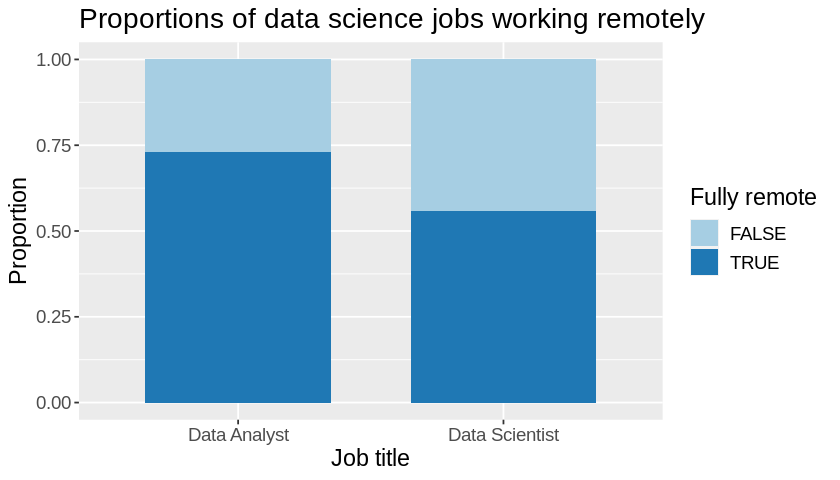

In [7]:
options(repr.plot.width = 7, repr.plot.height = 4)

# Create a bar graph with proportions represented by proprtions of the bar occupied by correspdoning coloer
remote_prop_visual <- salaries_new %>%
    filter(job_title == "Data Analyst" | job_title == "Data Scientist") %>%
    ggplot(aes(x = job_title, fill = remote_ratio == "remote")) +
    geom_bar(position = "fill", width = 0.7) +
    xlab("Job title") +
    ylab("Proportion") +
    ggtitle("Proportions of data science jobs working remotely") +
    labs(fill = "Fully remote") +
    scale_fill_brewer(palette = "Paired") +
    theme(text = element_text(size = 14))

remote_prop_visual

**Figure 2:** Proportion of dat ascience jobs working remotely.

# Estimates

Because we are interested in comparing salaries and remote work proportions , will gather point estimates. We excluded the analysis of company size because the distributions of salaries for some compnay sizes seemed too irregular to infer reliably from.

In [8]:
# We are only interested in data analyst and data scientist, so we filter these to job_titles out
salaries_new <- salaries_new %>%
        filter(job_title == "Data Analyst" | job_title == "Data Scientist")
head(salaries_new)
# Here, we will calculate basic point estimate statistics for future inferences.
data_estimates <- salaries_new %>%
    group_by(job_title) %>%
    summarize(n = n(),
              salary_mean = mean(salary_in_usd), 
              salary_sd = sd(salary_in_usd), 
              remote_prop = mean(remote_ratio == "remote"), 
              remote_sd = sqrt(remote_prop * (1 - remote_prop)))
    

# Preview point estimates
head(data_estimates)

work_year,experience_level,job_title,salary_in_usd,remote_ratio,company_size,n
<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<int>
2020,MI,Data Scientist,79833,in person,L,140
2020,EN,Data Scientist,51321,in person,S,140
2020,MI,Data Scientist,40481,in person,L,140
2020,EN,Data Scientist,39916,in person,M,140
2020,EN,Data Analyst,6072,in person,S,96
2020,EN,Data Scientist,49268,in person,S,140


job_title,n,salary_mean,salary_sd,remote_prop,remote_sd
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
Data Analyst,96,93752.84,39258.60,0.7291667,0.4443902
Data Scientist,140,108922.79,64372.43,0.5571429,0.4967240


# Methods

Up till now, the report has demonstrated differences in mean salaries and proportions of remote work among Data Scientists and Data Analysts. To ensure randomness, representative samples of full-time employees with sample sizes greater than 30 were used.
However, relying on point estimates and plots alone is not enough to establish these differences. Therefore, to address this issue, the report proposes using the Central Limit Theorem, as the samples are roughly normally distributed and less computationally intensive than resampling methods.
By letting Data Scientists be population 1, and Data Analysts as population 2, we aim to test the following hypothesis for the mean salary:
$$H_0 : \mu_2 - \mu_1 = 0$$
$$H_1 : \mu_2 - \mu_1 \neq 0$$

for the proportion of remote work:
$$H_0 : p_2 - p_1 = 0$$
$$H_1 : p_2 - p_1 \neq 0$$

where $\mu$ is the population's mean salary and $p$ is its proportion of employees working remotely. 

We expect to reject both null hypotheses, and will include a 90% confidence interval in our final report.

### Impact

The outcomes of these findings could affect the decisions of newly graduated data scientists in terms of which job positions to seek and which career paths to focus on during their undergraduate studies.

### Future

This prompts further questions about how differences in experience, company location, and company size may affect the comparison of job titles in the field of Data Science. Additionally, with more data, these issues can be explored for the other professions that were not thoroughly examined due to limitations in sample size and distribution.

# Result

In [49]:
#?ASK do we use standard error here? divide by n or not
# DennisL I think dont use standard error because its only for samploing distr. Since we have bootstrap, we only have SD?

# Seed set at initiation

# Using infer
analyst_bootstrapped_salary_sd <- salaries_new %>% 
    filter(job_title == "Data Analyst") %>%
    specify(response = salary_in_usd) %>% 
    generate(type = "bootstrap", reps = 1000) %>% 
    calculate(stat = "sd")

scientist_bootstrapped_salary_sd <- salaries_new %>% 
    filter(job_title == "Data Scientist") %>%
    specify(response = salary_in_usd) %>% 
    generate(type = "bootstrap", reps = 1000) %>% 
    calculate(stat = "sd")

head(analyst_bootstrapped_salary_sd)    
head(scientist_bootstrapped_salary_sd)    

# using traditional method
bootstrapped_samples <- salaries_new %>%
        ungroup() %>%
        rep_sample_n(size = nrow(salaries_new), reps = 1000, replace = TRUE) %>%
        group_by(replicate, job_title) %>% 
        summarise(salary_sd = sd(salary_in_usd),
                  ratio_sd = sqrt((mean(remote_ratio == "remote") * (1-mean(remote_ratio == "remote")))/n())) # standard deviation of sample proportion

head(bootstrap_samples)                                                         

replicate,stat
<int>,<dbl>
1,39858.46
2,40732.94
3,33935.93
4,33433.77
5,37488.17
6,42468.33


replicate,stat
<int>,<dbl>
1,74736.10
2,64476.57
3,69173.48
4,65545.62
5,64710.88
6,76302.01


`summarise()` has grouped output by 'replicate'. You can override using the
`.groups` argument.


replicate,job_title,salary_sd,remote_sd
<int>,<chr>,<dbl>,<dbl>
1,Data Analyst,37221.42,0.04716928
1,Data Scientist,62223.62,0.04192160
2,Data Analyst,37031.85,0.04511559
2,Data Scientist,68496.32,0.04249499
3,Data Analyst,42781.59,0.04976391
3,Data Scientist,59510.86,0.04035261


**Table 3:** Bootstrapped distribution based on 1000 replicates

In [47]:
# quantiles method
salary_sd_ci <- bootstrapped_samples %>%
        group_by(job_title) %>%
        summarise(lower_ci = quantile(salary_sd, 0.05),
                  upper_ci = quantile(salary_sd, 0.95))
salary_sd_ci


#  infer method
analyst_salary_ci <- analyst_bootstrapped_salary_sd %>% 
    get_ci(level = 0.9, type = "percentile")
scientist_salary_ci <- scientist_bootstrapped_salary_sd %>% 
    get_ci(level = 0.9, type = "percentile")
bind_rows(analyst_salary_ci, scientist_salary_ci) # Why are values different between quantiles sd and infer sd for salary?




ratio_sd_ci <- bootstrapped_samples %>%
        group_by(job_title) %>%
        summarise(lower_ci = quantile(ratio_sd, 0.05),
                  upper_ci = quantile(ratio_sd, 0.95))
ratio_sd_ci

job_title,lower_ci,upper_ci
<chr>,<dbl>,<dbl>
Data Analyst,34381.05,43636.93
Data Scientist,56053.26,74072.72


lower_ci,upper_ci
<dbl>,<dbl>
34620.55,43209.89
55838.25,74330.11


job_title,lower_ci,upper_ci
<chr>,<dbl>,<dbl>
Data Analyst,0.03999905,0.05010730
Data Scientist,0.03999837,0.04393047


**Table 4.** Confidence intervals of salary distributions and remote ratios.

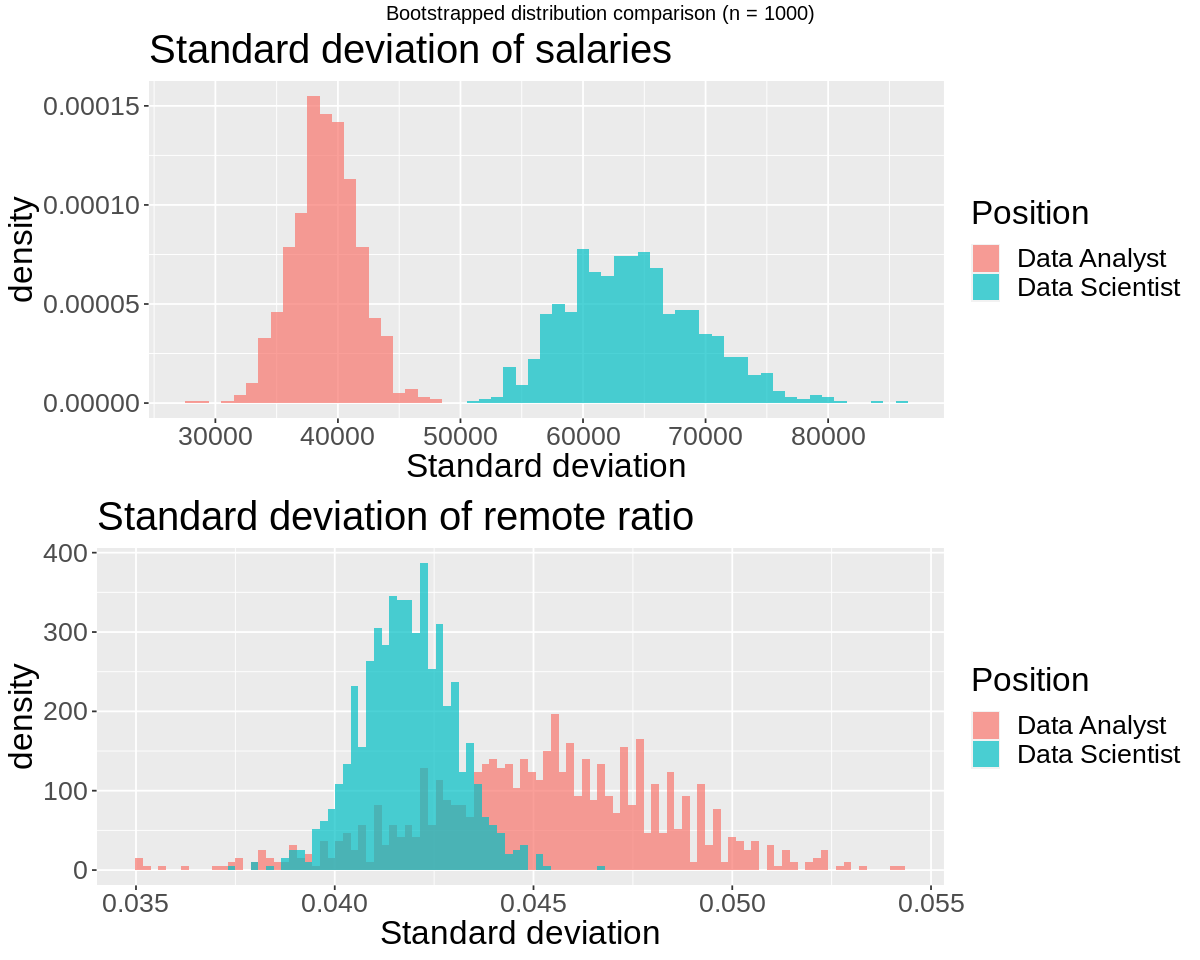

In [54]:
options(repr.plot.width = 10, repr.plot.height = 8) # setting dimensions

# plotting the salary sd distribution
bootstrap_dist_salary_sd <- bootstrapped_samples %>%
    ggplot(aes(x = salary_sd, y = ..density.., fill = job_title)) +
    geom_histogram(binwidth = 1000, position = "identity", alpha = 0.7) +
    xlab("Standard deviation") +
    ggtitle("Standard deviation of salaries") +
    labs(fill = "Position") +
    theme(text = element_text(size = 20))

# plotting the remote prop. sd distribution
bootstrap_dist_ratio_sd <- bootstrapped_samples %>%
    ggplot(aes(x = ratio_sd, y = ..density.., fill = job_title)) +
    geom_histogram(bins = 100, position = "identity", alpha = 0.7) +
    xlab("Standard deviation") +
    ggtitle("Standard deviation of remote ratio") +
    labs(fill = "Position") +
    theme(text = element_text(size = 20))

grid.arrange(bootstrap_dist_salary_sd, bootstrap_dist_ratio_sd, top = "Bootstrapped distribution comparison (n = 1000)")

**Figure 3.** Bootstrap distributions of standard deviation of salaries and remote work ratios for Data Analysts and Data Scientists.


Data scientist salaries are less stable than Data analyst salaries because its dsitribution is higher, with the data scientists salary's 90% confidence interval being nearly two times wider at around 18019.46 USD wide compared to the 9255.88 USD wide 90% confidence interval of data analyst salaries (Table 3). The standard deviations of the salaries does not overlap, highlighting the how data scientist salaries vary with a higher and wider magnitude (Figure 3).

The distributions of remote ratios of data scientists was also less stable than data analysts, with data scientists having a 90% confidence interval that was 10.10825% wide, while data analysts had a 90% confidence interval that was 2.5 times smaller at 3.9321% wide (Table 3). We can also see that the standard deviation for data scientists' remote work is much more stable because it has a narrower distribution that the standard deviation of data analysts' remote work ratio (Figure 3).

## Hypothesis testings

In [11]:
data_estimates

job_title,n,salary_mean,salary_sd,remote_prop,remote_sd
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
Data Analyst,96,93752.84,39258.60,0.7291667,0.4443902
Data Scientist,140,108922.79,64372.43,0.5571429,0.4967240


In [12]:
# for difference in salary means

# numerator <- data_estimates %>%
#         summarise(diff_in_mean = 
# t_statistic_mean <- (data_estimates)

#?ASK im try to do two-sample-ttest here, not sure what does the error means
head(salaries_new)
analyst <- salaries_new %>%
        filter(job_title == "Data Analyst") %>%
        select(salary_in_usd)
scientist <- salaries_new %>%
        filter(job_title == "Data Scientist") %>%
        select(salary_in_usd)
t_test_diff_mean <- 
    tidy(
        t.test(x = analyst,
               y = scientist,
               alternative = "two.sided"))

# adelie <- adelie_chin %>%
#         filter(species == "Adelie") %>%
#         select(flipper_length_mm)
# chin <- adelie_chin %>%
#         filter(species == "Chinstrap") %>%
#         select(flipper_length_mm)
# answer3.3.6 <- 
#     tidy(
#         t.test(x = chin,
#                y = adelie,
#                alternative = "two.sided"))

work_year,experience_level,job_title,salary_in_usd,remote_ratio,company_size,n
<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<int>
2020,MI,Data Scientist,79833,in person,L,140
2020,EN,Data Scientist,51321,in person,S,140
2020,MI,Data Scientist,40481,in person,L,140
2020,EN,Data Scientist,39916,in person,M,140
2020,EN,Data Analyst,6072,in person,S,96
2020,EN,Data Scientist,49268,in person,S,140


Adding missing grouping variables: `job_title`
Adding missing grouping variables: `job_title`


ERROR: [1m[33mError[39m:[22m
[33m![39m Can't combine `job_title` <character> and `salary_in_usd` <double>.


In [ ]:
# answer3.4.4 <- tidy(
#     prop.test(x = c(sum(high$contraceptive == "Yes"), sum(low$contraceptive == "Yes")), # an array with the number of successes in each sample
#                   n = c(nrow(high),nrow(low)), # an array with the size of each sample
#                   correct = FALSE))     
analyst_prop <- salaries_new %>%
        filter(job_title == "Data Analyst") 
scientist_prop <- salaries_new %>%
        filter(job_title == "Data Scientist") 
head(salaries_new)
prop_test <- tidy(
    prop.test(x = c(sum(analyst$remote_ratio == "remote"), sum(scientist$remote_ratio == "remote")),
              n = c(nrow(analyst_prop), nrow(scientist_prop)),
              correct = FALSE))
prop_test

# References

Bhatia, R. (2022). *Data science job salaries*. https://www.kaggle.com/datasets/ruchi798/data-science-job-salaries

Card, D., Mas, A., Moretti, E., & Saez, E. (2012). Inequality at work: The effect of peer salaries on job satisfaction. *American Economic Review*, 102(6), 2981–3003. https://doi.org/10.1257/aer.102.6.2981

Galanti, T., Guidetti, G., Mazzei, E., Zappalà, S., & Toscano, F. (2021). Work from home during the COVID-19 outbreak: the impact on employees' remote work productivity, engagement, and stress. *Journal of Occupational and Environmental Medicine*, 63(7), e426–e432. https://doi.org/10.1097/JOM.0000000000002236